# Supervised Learning: Heart Failure Prediction (Kaggle Dataset)

<p align="center">
  <img width=800 src="https://heart-failure.net/wp-content/uploads/2020/10/HF-living-ejection-fraction-differences.jpg"/>
</p>

**Context**

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**Attribute Information**

1. **Age**: age of the patient [years]
1. **Sex**: sex of the patient [M: Male, F: Female]
1. **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
1. **RestingBP**: resting blood pressure [mm Hg]
1. **Cholesterol**: serum cholesterol [mm/dl]
1. **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
1. **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
1. **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
1. **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
1. **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
1. **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
1. **HeartDisease**: output class [1: heart disease, 0: Normal]

## Import Libraries and Dataset

In [211]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from statsmodels.api import OLS
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [107]:
df_ori = pd.read_csv('heart.csv')
df = df_ori.copy()
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [108]:
print('Shape of the dataset is:',df.shape)

Shape of the dataset is: (918, 12)


## Exploratory Data Analysis

In [109]:
numerical = df.drop(columns=['HeartDisease','FastingBS']).select_dtypes('number').columns
categorical = set(df.drop(columns=['HeartDisease']).columns)-set(numerical)
print('Numerical Columns  :',df[numerical].columns)
print('Categorical Columns:',df[categorical].columns) 

Numerical Columns  : Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], dtype='object')
Categorical Columns: Index(['FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG',
       'ST_Slope', 'Sex'],
      dtype='object')


In [212]:
df[numerical].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [110]:
for i in categorical:
    display(pd.DataFrame(df[i].value_counts()))

,FastingBS
0,704
1,214


,ExerciseAngina
N,547
Y,371


,ChestPainType
ASY,496
NAP,203
ATA,173
TA,46


,RestingECG
Normal,552
LVH,188
ST,178


,ST_Slope
Flat,460
Up,395
Down,63


,Sex
M,725
F,193


In [111]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [112]:
print(categorical)

{'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope', 'Sex'}


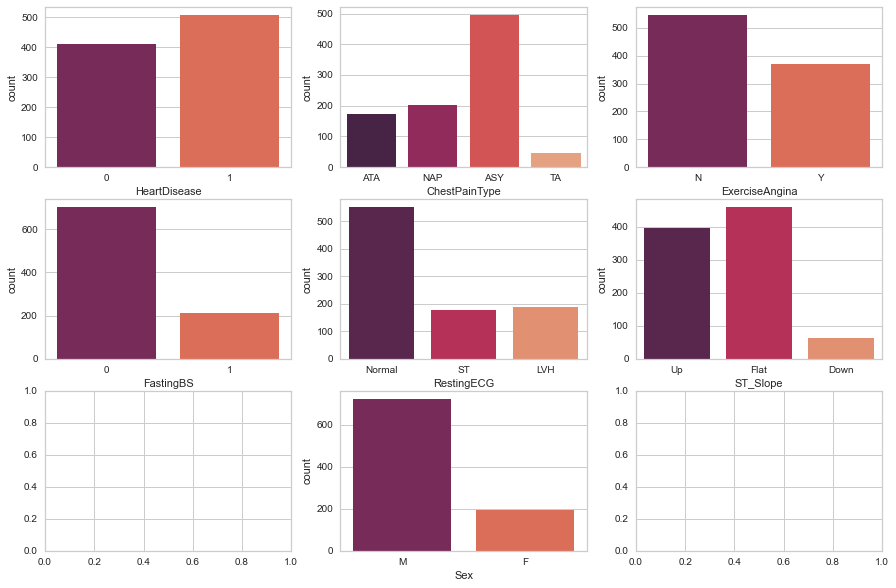

In [113]:
f, axes = plt.subplots(3, 3, figsize=(15, 10))

sns.countplot(x = df['HeartDisease'], data = df, palette='rocket', ax=axes[0,0])
sns.countplot(x = df['ChestPainType'], data = df, palette='rocket', ax=axes[0,1])
sns.countplot(x = df['ExerciseAngina'], data = df, palette='rocket', ax=axes[0,2])

sns.countplot(x = df['FastingBS'], data = df, palette='rocket', ax=axes[1,0])
sns.countplot(x = df['RestingECG'], data = df, palette='rocket', ax=axes[1,1])
sns.countplot(x = df['ST_Slope'], data = df, palette='rocket', ax=axes[1,2])

sns.countplot(x = df['Sex'], data = df, palette='rocket', ax=axes[2,1])
plt.show()

## Data Cleansing

In [114]:
def desc_data(df):
    df_describe = []
    for i in df.columns: 
          df_describe.append([
          i,
          df[i].dtypes,
          df[i].isna().sum(),
          round((((df[i].isna().sum())/(len(df)))*100),2),
          df[i].nunique(),
          df[i].unique() 
      ])
    return pd.DataFrame(df_describe, columns=['column','type','nan','nan%','nunique','unique'])
display(desc_data(df))
print('Total duplicated data:',df.duplicated().sum())

,column,type,nan,nan%,nunique,unique
0,Age,int64,0,0.0,50,"[40, 49, 37, 48, 54, 39, 45, 58, 42, 38, 43, 6..."
1,Sex,object,0,0.0,2,"[M, F]"
2,ChestPainType,object,0,0.0,4,"[ATA, NAP, ASY, TA]"
3,RestingBP,int64,0,0.0,67,"[140, 160, 130, 138, 150, 120, 110, 136, 115, ..."
4,Cholesterol,int64,0,0.0,222,"[289, 180, 283, 214, 195, 339, 237, 208, 207, ..."
5,FastingBS,int64,0,0.0,2,"[0, 1]"
6,RestingECG,object,0,0.0,3,"[Normal, ST, LVH]"
7,MaxHR,int64,0,0.0,119,"[172, 156, 98, 108, 122, 170, 142, 130, 120, 9..."
8,ExerciseAngina,object,0,0.0,2,"[N, Y]"
9,Oldpeak,float64,0,0.0,53,"[0.0, 1.0, 1.5, 2.0, 3.0, 4.0, 0.5, 2.5, 5.0, ..."


Total duplicated data: 0


- Data types looks fine
- No missing values
- No duplicate data

In [115]:
# def boxplotOutlier(col):
#     plt.figure(figsize=(2,7))
#     sns.boxplot(y = df[col])
#     plt.ylabel(col, fontsize = 20)
    
# for i in numerical:
#     boxplotOutlier(i)

In [116]:
# print('Before removing outlier:',df.shape)
# df = df[df.RestingBP>90][df.RestingBP<170]
# df = df[df.Cholesterol>50][df.Cholesterol<410]
# df = df[df.MaxHR>66]
# df = df[df.Oldpeak>-2][df.Oldpeak<3.8]
# print('After removing outlier:',df.shape)

## Data Preprocessing

**Encode**

In [162]:
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded,columns=categorical)
# df_encoded.drop(columns=categorical,inplace=True)
display(df_encoded.head())
print('Column of the dataset before encode is:',df.shape[1])
print('Column of the dataset after encode is:',df_encoded.shape[1])

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,FastingBS_0,FastingBS_1,ExerciseAngina_N,ExerciseAngina_Y,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Sex_F,Sex_M
0,40,140,289,172,0.0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
1,49,160,180,156,1.0,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
2,37,130,283,98,0.0,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,1
3,48,138,214,108,1.5,1,1,0,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,122,0.0,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,1


Column of the dataset before encode is: 12
Column of the dataset after encode is: 22


**Standard Scaler**

In [169]:
features = set(df_encoded.columns)-set(['HeartDisease'])
target = 'HeartDisease'

In [171]:
scaler = StandardScaler()
scaler.fit(df_encoded[features])
df_scaled = pd.DataFrame(scaler.transform(df_encoded[features]),columns=df_encoded[features].columns)
df_scaled.head()

,ChestPainType_ATA,FastingBS_0,ExerciseAngina_Y,RestingECG_ST,MaxHR,Cholesterol,ST_Slope_Down,ExerciseAngina_N,Age,ChestPainType_ASY,...,Oldpeak,Sex_M,Sex_F,RestingECG_Normal,ChestPainType_TA,FastingBS_1,ChestPainType_NAP,ST_Slope_Up,ST_Slope_Flat,RestingBP
0,2.075177,0.551341,-0.823556,-0.490449,1.382928,0.825070,-0.271448,0.823556,-1.433140,-1.084138,...,-0.832432,0.515952,-0.515952,0.814275,-0.229679,-0.551341,-0.532838,1.150674,-1.002181,0.410909
1,-0.481887,0.551341,-0.823556,-0.490449,0.754157,-0.171961,-0.271448,0.823556,-0.478484,-1.084138,...,0.105664,-1.938163,1.938163,0.814275,-0.229679,-0.551341,1.876744,-0.869056,0.997824,1.491752
2,2.075177,0.551341,-0.823556,2.038947,-1.525138,0.770188,-0.271448,0.823556,-1.751359,-1.084138,...,-0.832432,0.515952,-0.515952,-1.228087,-0.229679,-0.551341,-0.532838,1.150674,-1.002181,-0.129513
3,-0.481887,0.551341,1.214246,-0.490449,-1.132156,0.139040,-0.271448,-1.214246,-0.584556,0.922392,...,0.574711,-1.938163,1.938163,0.814275,-0.229679,-0.551341,-0.532838,-0.869056,0.997824,0.302825
4,-0.481887,0.551341,-0.823556,-0.490449,-0.581981,-0.034755,-0.271448,0.823556,0.051881,-1.084138,...,-0.832432,0.515952,-0.515952,0.814275,-0.229679,-0.551341,1.876744,1.150674,-1.002181,0.951331


**Train Test Split**

In [173]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled[features],df_encoded[target],test_size=0.2,random_state=20)
print('Shape of X_train',X_train.shape)
print('Shape of y_train',y_train.shape)
print('Shape of X_test',X_test.shape)
print('Shape of y_test',y_test.shape)

Shape of X_train (734, 21)
Shape of y_train (734,)
Shape of X_test (184, 21)
Shape of y_test (184,)


**Correlation**

In [175]:
df_encoded.corr(method='pearson')['HeartDisease'].sort_values(ascending=False)

HeartDisease         1.000000
ST_Slope_Flat        0.554134
ChestPainType_ASY    0.516716
ExerciseAngina_Y     0.494282
Oldpeak              0.403951
Sex_M                0.305445
Age                  0.282039
FastingBS_1          0.267291
ST_Slope_Down        0.122527
RestingBP            0.107589
RestingECG_ST        0.102527
RestingECG_LVH       0.010670
ChestPainType_TA    -0.054790
RestingECG_Normal   -0.091580
ChestPainType_NAP   -0.212964
Cholesterol         -0.232741
FastingBS_0         -0.267291
Sex_F               -0.305445
MaxHR               -0.400421
ChestPainType_ATA   -0.401924
ExerciseAngina_N    -0.494282
ST_Slope_Up         -0.622164
Name: HeartDisease, dtype: float64

"ST_Slope_Flat", "ChestPainType_ASY", "ExerciseAngina_Y" is the top 3 most correlate with target feature "HeartDisease".

## Model Selection

**Logistic Regression**

In [176]:
sm_lm = OLS(y_train, sm.add_constant(X_train))
result = sm_lm.fit()
y_pred_prob_ols = result.predict(sm.add_constant(X_test))
y_pred_ols = np.where(y_pred_prob_ols>0.5,1,0)
print('Logistic Regression Model Accuracy:',accuracy_score(y_test,y_pred_ols))

Logistic Regression Model Accuracy: 0.8586956521739131


**Naive Bayes**

In [184]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print('Naive Bayes Model Accuracy:',accuracy_score(y_test,y_pred_nb))

Naive Bayes Model Accuracy: 0.8641304347826086


**KNN**

Text(0, 0.5, 'Error rate')

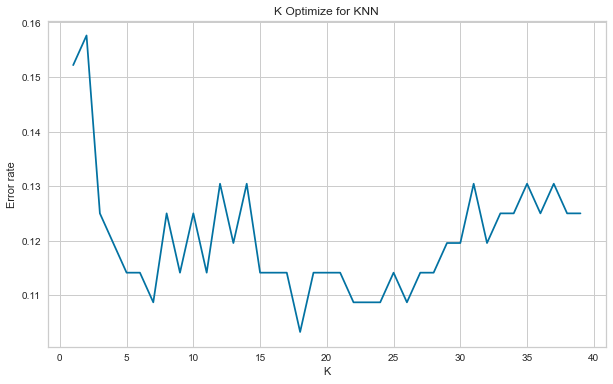

In [178]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i!=y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate)
plt.title('K Optimize for KNN')
plt.xlabel('K')
plt.ylabel('Error rate')

As we can see, the smallest error rate is with K value = 18. So we're going to use n neighbors = 18 for KNN model.

In [179]:
bestErrorRate = error_rate.index(min(error_rate))+1
knn = KNeighborsClassifier(n_neighbors=bestErrorRate)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test) 
print(classification_report(y_test,y_pred_knn))
print('Best K =',bestErrorRate)
print('KNN Model Accuracy:',accuracy_score(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89        85
           1       0.90      0.91      0.90        99

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Best K = 18
KNN Model Accuracy: 0.8967391304347826


**Decision Tree**

In [185]:
tree = DecisionTreeClassifier(criterion = 'gini',max_depth=2)
tree.fit(X_train,y_train)
y_pred_tree = tree.predict(X_test)
print(classification_report(y_test,y_pred_tree))
print('KNN Model Accuracy:',accuracy_score(y_test,y_pred_tree))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79        85
           1       0.80      0.88      0.84        99

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184

KNN Model Accuracy: 0.8152173913043478


**SVM**

In [186]:
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
print(classification_report(y_test,y_pred_svm))
print("AdaBoost Classifier Model Accuracy:",accuracy_score(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87        85
           1       0.88      0.92      0.90        99

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

AdaBoost Classifier Model Accuracy: 0.8858695652173914


**Adaboost**

In [180]:
abc = AdaBoostClassifier(n_estimators=500,learning_rate=0.01,random_state=20)
model = abc.fit(X_train,y_train)
y_pred_adaboost = model.predict(X_test)
print(classification_report(y_test,y_pred_adaboost))
print("AdaBoost Classifier Model Accuracy:",accuracy_score(y_test, y_pred_adaboost))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        85
           1       0.85      0.93      0.89        99

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184

AdaBoost Classifier Model Accuracy: 0.875


**XGBoost**

In [181]:
gbc = GradientBoostingClassifier(n_estimators=500,learning_rate=0.01,random_state=20)
model = gbc.fit(X_train,y_train)
y_pred_xgboost = model.predict(X_test)
print(classification_report(y_test,y_pred_xgboost))
print("XGBoost Classifier Model Accuracy:",accuracy_score(y_test,y_pred_xgboost))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85        85
           1       0.85      0.91      0.88        99

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184

XGBoost Classifier Model Accuracy: 0.8641304347826086


## Comparasion Between Models

In [209]:
modelName = ['Logistic Regression','Naive Bayes','KNN','Decision Tree','SVM','Adaboost','XGBoost']
preds = [y_pred_ols,y_pred_nb,y_pred_knn,y_pred_tree,y_pred_svm,y_pred_adaboost,y_pred_xgboost]
accs = []
for i in preds:
    accs.append(accuracy_score(y_test,i))
df_model = pd.DataFrame({'Model':modelName,'Accuracy':accs})
df_model.sort_values('Accuracy',ascending=False).reset_index(drop=True)

,Model,Accuracy
0,KNN,0.896739
1,SVM,0.885870
2,Adaboost,0.875000
3,Naive Bayes,0.864130
4,XGBoost,0.864130
5,Logistic Regression,0.858696
6,Decision Tree,0.815217


Text(0.5, 1.0, 'Accuracy Comparasion Between Models')

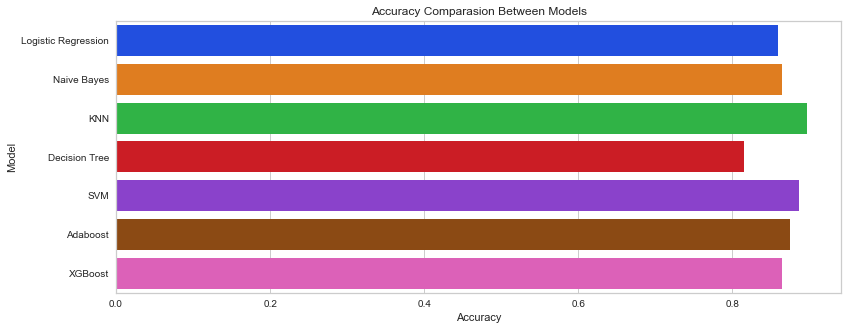

In [210]:
plt.figure(figsize=(13,5))
sns.barplot(x='Accuracy', y='Model', data=df_model, palette='bright')
plt.title('Accuracy Comparasion Between Models')

KNN is the winner with 89.7% Accuracy.

## References
1. [Heart Failure Prediction Dataset (Kaggle Dataset) - Kaggle](https://www.kaggle.com/fedesoriano/heart-failure-prediction/)
1. [K-Nearest Neighbors Algorithm In Python, by example - Towardsdatascience](https://towardsdatascience.com/k-nearest-neighbors-algorithm-in-python-by-example-79abc37a4443)
1. [5 Types of Classification Algorithms in Machine Learning - Monkeylearn](https://monkeylearn.com/blog/classification-algorithms/)
1. [Heart failure prediction using Adaboost & XGboost - Kaggle](https://www.kaggle.com/ysthehurricane/heart-failure-prediction-using-adaboost-xgboost)
1. []()